In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

# El modelo de dislocación de Okada (1985)

Basado en la [función de Matlab de François Beauducel (Copyright 1997-2012)](http://www.mathworks.com/matlabcentral/fileexchange/25982-okada--surface-deformation-due-to-a-finite-rectangular-source). Śólo me interesa la componente vertical de desplazamiento.

In [2]:
def chinnery(f,x,p,L,W,q,dip,nu):
    u = f(x,p,q,dip,nu) \
    - f(x,p-W,q,dip,nu) \
    - f(x-L,p,q,dip,nu) \
    + f(x-L,p-W,q,dip,nu)
    return u

In [3]:
def I4(db,eta,q,dip,nu,R):
    I = 0.0*eta
    if (np.cos(dip)>np.finfo(1.0).eps):
        I = (1.-2*nu)*1./np.cos(dip)*(np.log(R+db)-np.sin(dip)*np.log(R+eta))
    else:
        I = -(1.-2.*nu)*q/(R+db)
    return I

In [4]:
def I5(xi,eta,q,dip,nu,R,db):
    X = np.sqrt(xi**2+q**2)
    I = 0.0*xi
    if np.cos(dip)>np.finfo(1.0).eps:
        I = (1-2.*nu)*2./np.cos(dip) \
                    *np.arctan( (eta*(X+q*np.cos(dip)) + X*(R+X)*np.sin(dip)  ) \
                    /(xi*(R+X)*np.cos(dip)))
        I = np.where(np.isclose(xi,0.0),0.0,I)
    else:
        I = -(1-2*nu)*xi*np.sin(dip)/(R+db)
    return I 

In [5]:
def uz_ss(xi,eta,q,dip,nu):
    R = np.sqrt(xi**2+eta**2+q**2)
    db = eta*np.sin(dip) - q*np.cos(dip)
    u = (eta*np.sin(dip)-q*np.cos(dip))*q/(R*(R+eta)) \
        + q*np.sin(dip)/(R+eta) \
        + I4(db,eta,q,dip,nu,R)*np.sin(dip)
    return u

In [6]:
def uz_ds(xi,eta,q,dip,nu):
    R = np.sqrt(xi**2+eta**2+q**2)
    db = eta*np.sin(dip) - q*np.cos(dip)
    u = db*q/(R*(R+xi)) \
        - I5(xi,eta,q,dip,nu,R,db)*np.sin(dip)*np.cos(dip)
    u = np.where(q!=0.0,
                 u+np.arctan((xi*eta)/(q*R)),
                 u)
    return u

In [7]:
def uz_tf(xi,eta,q,dip,nu):
    R = np.sqrt(xi**2+eta**2+q**2)
    db = eta*np.sin(dip) - q *np.cos(dip)
    u = (eta*np.cos(dip) + q*np.sin(dip))*q/(R*(R+xi)) \
        + np.cos(dip)*xi*q/(R*(R+eta)) \
        - I5(xi,eta,q,dip,nu,R,db)*np.sin(dip)**2
    u = np.where( q!=0.0, 
                 u - np.cos(dip)*np.arctan(xi*eta/(q*R)),
                u)
    return u

In [8]:
def okada(n,e,depth,strike,dip,L,W,rake,slip,U3):
    nu = 0.25
    strike = strike*np.pi/180.
    dip = dip*np.pi/180.
    rake = rake*np.pi/180.
    
    U1 = np.cos(rake)*slip
    U2 = np.sin(rake)*slip
    
    d = depth + np.sin(dip)*W/2.0
    ec = e + np.cos(strike)*np.cos(dip)*W/2.0
    nc = n - np.sin(strike)*np.cos(dip)*W/2.0
    x = np.cos(strike)*nc + np.sin(strike)*ec+L/2.0
    y = np.sin(strike)*nc - np.cos(strike)*ec + np.cos(dip)*W    
    
    p = y*np.cos(dip) + d*np.sin(dip)
    q = y*np.sin(dip) - d*np.cos(dip)    
    
    uz = -U1/(2.*np.pi) * chinnery(uz_ss,x,p,L,W,q,dip,nu) \
        - U2/(2.*np.pi) * chinnery(uz_ds,x,p,L,W,q,dip,nu) \
        + U3/(2.*np.pi) * chinnery(uz_tf,x,p,L,W,q,dip,nu)    
    return uz

# Ejemplo

In [9]:
e,n = np.meshgrid(np.linspace(-10,10,100),np.linspace(-10,10,100))

In [10]:
depth = 2.
strike = 30.
dip = 70.
L = 5.
W = 3.
rake = -45.
slip = 1.0
U3 = 1.0

uz1  = okada(n,e,depth,strike,dip,L,W,rake,slip,U3)

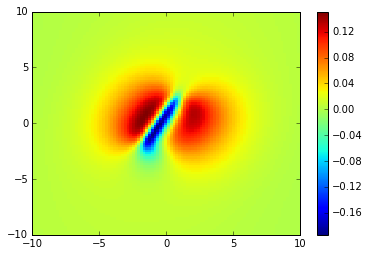

In [11]:
plt.pcolormesh(e,n,uz1)
plt.colorbar()

# Muchas subfallas: USGS Chile 2010

In [12]:
import utm

In [13]:
def multi_okada(e,n,xy,depth,strike,dip,L,W,rake,slip):
    nfault = data.shape[0]
    uz = np.zeros_like(e)
    for i in range(nfault):
        ce = xy[i,0]
        cn = xy[i,1]
        U3 = 0.0
        uz  += okada(n-cn,e-ce,depth[i],strike[i],dip[i],L[i],W[i],rake[i],slip[i],U3)
    return uz

In [14]:
data = np.loadtxt('static_out.txt',skiprows=10)
xy = np.array([utm.from_latlon(data[i,0],data[i,1],force_zone_number=18)[0:2] for i in range(data.shape[0])])

In [15]:
e = np.linspace(xy[:,0].min(),xy[:,0].max(),100)
n = np.linspace(xy[:,1].min(),xy[:,1].max(),100)
e,n = np.meshgrid(e,n)

In [16]:
depth = data[:,2]*1000.
strike = data[:,5]
dip = data[:,6]
L = 30000.*np.ones((data.shape[0],))
W = 20000.*np.ones((data.shape[0],))
rake =   data[:,4]
slip =  data[:,3]

In [17]:
uz = multi_okada(e,n,xy,depth,strike,dip,L,W,rake,slip)

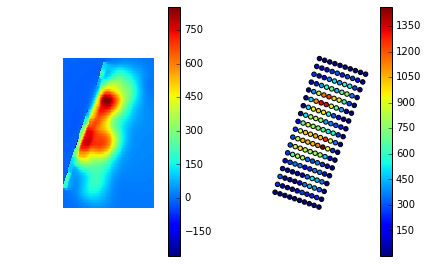

In [45]:
plt.subplot(121)
plt.pcolormesh(e,n,uz)
plt.colorbar()
plt.axis('equal');
plt.axis('off')

plt.subplot(122)
plt.scatter(xy[:,0],xy[:,1],c=data[:,3])
plt.colorbar()
plt.axis('equal');
plt.axis('off')

plt.tight_layout()


## Junto a la topografía

In [21]:
from scipy.io import loadmat
h = loadmat('../../../MorenoCS_h')

In [22]:
xb = h['xh'][0,0][0,:]
yb = h['yh'][0,0][0,:]
zb = h['zh'][0,0]

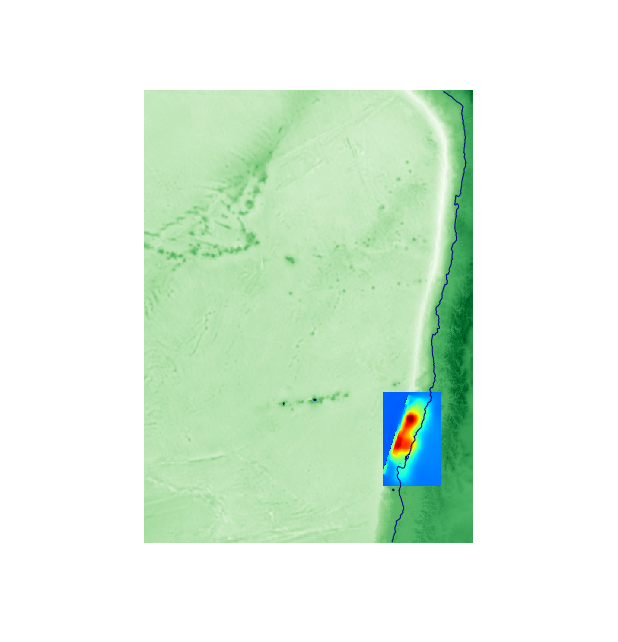

In [38]:
plt.figure(figsize=(9,9))
plt.pcolormesh(xb,yb,zb,cmap=plt.cm.Greens)
plt.contour(xb,yb,zb,[0.0])
plt.pcolormesh(e,n,uz)
plt.axis('equal')
plt.axis('off')
plt.tight_layout()